In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_process import TrajectoryDataset
from experiments.robot.libero.libero_utils import (
    get_libero_dummy_action,
    get_libero_env,
    get_libero_image,
    quat2axisangle,
    save_rollout_video_CoA,
)
from config import GenerateConfig
import matplotlib.pyplot as plt
from model_utils import setup_vla_model_with_lora, setup_model_and_config, setup_logging_and_environment
from torch.utils.data import DataLoader
from trl.trainer.dpo_trainer import DataCollatorForPreference

2025-08-29 16:09:52.154317: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-29 16:09:52.154380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-29 16:09:52.155899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-29 16:09:52.167813: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-29 16:09:53.060086: W tensorflow/comp

08/29 [16:10:15] WARNING  | >> No private macro file found!                                            ]8;id=247108;file:///home/zijianwang/miniconda3/envs/openvla/lib/python3.10/site-packages/robosuite/macros.py\macros.py]8;;\:]8;id=643565;file:///home/zijianwang/miniconda3/envs/openvla/lib/python3.10/site-packages/robosuite/macros.py#53\53]8;;\

[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)


                 WARNING  | >> It is recommended to use a private macro file                           ]8;id=929118;file:///home/zijianwang/miniconda3/envs/openvla/lib/python3.10/site-packages/robosuite/macros.py\macros.py]8;;\:]8;id=19207;file:///home/zijianwang/miniconda3/envs/openvla/lib/python3.10/site-packages/robosuite/macros.py#54\54]8;;\

[robosuite WARNING] To setup, run: python /home/zijianwang/miniconda3/envs/openvla/lib/python3.10/site-packages/robosuite/scripts/setup_macros.py (macros.py:55)


                 WARNING  | >> To setup, run: python                                                   ]8;id=576132;file:///home/zijianwang/miniconda3/envs/openvla/lib/python3.10/site-packages/robosuite/macros.py\macros.py]8;;\:]8;id=674651;file:///home/zijianwang/miniconda3/envs/openvla/lib/python3.10/site-packages/robosuite/macros.py#55\55]8;;\
                          /home/zijianwang/miniconda3/envs/openvla/lib/python3.10/site-packages/robosu             
                          ite/scripts/setup_macros.py                                                              

                 INFO     | >> No OpenGL_accelerate module loaded: No module named          ]8;id=107723;file:///home/zijianwang/miniconda3/envs/openvla/lib/python3.10/site-packages/OpenGL/acceleratesupport.py\acceleratesupport.py]8;;\:]8;id=441343;file:///home/zijianwang/miniconda3/envs/openvla/lib/python3.10/site-packages/OpenGL/acceleratesupport.py#24\24]8;;\
                          'OpenGL_accelerate'                                                                      

08/29 [16:10:16] INFO     | >> TensorFlow version 2.15.0 available.                                   ]8;id=694637;file:///home/zijianwang/miniconda3/envs/openvla/lib/python3.10/site-packages/datasets/config.py\config.py]8;;\:]8;id=105300;file:///home/zijianwang/miniconda3/envs/openvla/lib/python3.10/site-packages/datasets/config.py#112\112]8;;\

In [3]:
import torch
import numpy as np
from typing import List
from experiments.robot.robot_utils import (
    invert_gripper_action,
    normalize_gripper_action,
)

def spilt_chain_to_units(chain: torch.Tensor, unnorm_key):
    """Split action chain into individual action units."""
    ACTION_DIM = 7
    # Assert chain dimensions
    assert chain.shape[0] == 1, f"Expected batch size 1, got {chain.shape[0]}"
    unit_length = ACTION_DIM # Each unit has 7 action dims
    assert chain.shape[1] % unit_length == 0, f"Chain length {chain.shape[1]} is not divisible by unit length {unit_length}"
    
    # Split chain into units
    num_units = chain.shape[1] // unit_length
    units = []
    for i in range(num_units):
        start_idx = i * unit_length
        end_idx = start_idx + unit_length
        unit = chain[:, start_idx:end_idx]
        units.append(unit)
        # assert unit[:,-1] == 32001, f"Unit {i} does not end with separator token 32001"
    return units


def process_action_unit(model, units: List[torch.Tensor], unnorm_key) -> List[np.ndarray]:
    """Process action units and convert to continuous actions."""
    processed_units = []
    for unit in units:
        # Extract predicted action tokens and translate into (normalized) continuous actions
        predicted_action_token_ids = unit[0, :model.get_action_dim(unnorm_key)].cpu().numpy()
        discretized_actions = model.vocab_size - predicted_action_token_ids
        discretized_actions = np.clip(discretized_actions - 1, a_min=0, a_max=model.bin_centers.shape[0] - 1)
        normalized_actions = model.bin_centers[discretized_actions]

        # Unnormalize actions
        action_norm_stats = model.get_action_stats(unnorm_key)
        mask = action_norm_stats.get("mask", np.ones_like(action_norm_stats["q01"], dtype=bool))
        action_high, action_low = np.array(action_norm_stats["q99"]), np.array(action_norm_stats["q01"])
        action = np.where(
            mask,
            0.5 * (normalized_actions + 1) * (action_high - action_low) + action_low,
            normalized_actions,
        )
        action = normalize_gripper_action(action, binarize=True)
        action = invert_gripper_action(action)
        processed_units.append(action)
    return processed_units

def setup_data_loader(cfg, processor, model, env, task_suite, resize_size):
    """Setup the training data loader."""
    print("[*] Setting up dataset and data loader...")
    
    # Create dataset instance
    dataset = TrajectoryDataset(
        cfg, 
        cfg.winner_trajectory_path, 
        cfg.task_suite_name, 
        processor, 
        env, 
        task_suite,
        device=cfg.device, 
        model=model, 
        img_size=resize_size,
        stream_length=cfg.stream_length,
        task_num=cfg.task_num
    )
    
    # Create data collator
    data_collator = DataCollatorForPreference(pad_token_id=processor.tokenizer.pad_token_id)
    
    # Create data loader
    train_dataloader = DataLoader(
        dataset,
        batch_size=cfg.batch_size,
        shuffle=True,
        collate_fn=data_collator
    )
    
    print(f"Dataset created with {len(dataset)} trajectory pairs")
    return train_dataloader

In [4]:
cfg = GenerateConfig(device = "cuda:0", stream_length = 20, task_num = 1, batch_size = 1)
print(cfg)

GenerateConfig(vla_path='openvla/openvla-7b', root_dir='/mnt/sda/home/zijianwang', use_lora=True, lora_rank=48, lora_dropout=0.0, model_family='openvla', dataset_name='libero_10_no_noops', task_num=1, pretrained_checkpoint='/mnt/sda/home/zijianwang/openvla/FT_res/openvla-7b-finetuned-libero-10+libero_10_no_noops+b4+lr-0.0005+lora-r48+dropout-0.0--image_aug--2025-07-18_19-26-25', lora_path='/mnt/sda/home/zijianwang/openvla/adapter_tmp_dir/openvla-7b-finetuned-libero-10+libero_10_no_noops+b4+lr-0.0005+lora-r48+dropout-0.0--image_aug--2025-07-18_19-26-25', base_vla_path='/mnt/sda/home/zijianwang/HF_CACHE/openvla-7b-finetuned-libero-10', winner_trajectory_path='/mnt/sda/home/zijianwang/openvla/vla-scripts/DPO/winner_trajectory', adapter_tmp_dir='/mnt/sda/home/zijianwang/openvla/DPO_adapter_tmp_dir', run_root_dir='', load_in_8bit=False, load_in_4bit=False, center_crop=True, batch_size=1, grad_accumulation_steps=1, learning_rate=0.0005, max_steps=10000, dpo_beta=0.1, stream_length=20, task_s

In [5]:
model = setup_vla_model_with_lora(cfg)

[*] Instantiating Pretrained VLA model
[*] Loading in BF16 with Flash-Attention Enabled


08/29 [16:10:27] WARNING  | >> Expected `transformers==4.40.1` and `tokenizers==0.19.1`   ]8;id=75954;file:///home/zijianwang/.cache/huggingface/modules/transformers_modules/openvla/openvla-7b/31f090d05236101ebfc381b61c674dd4746d4ce0/modeling_prismatic.py\modeling_prismatic.py]8;;\:]8;id=861168;file:///home/zijianwang/.cache/huggingface/modules/transformers_modules/openvla/openvla-7b/31f090d05236101ebfc381b61c674dd4746d4ce0/modeling_prismatic.py#228\228]8;;\
                          but got `transformers==4.53.3` and `tokenizers==0.21.2`; there                           
                          might be inference-time regressions due to dependency changes.                           
                          If in doubt, pleaseuse the above versions.                                               

Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 10.23it/s]


In [34]:
processor, log_file, task_suite, num_tasks_in_suite, resize_size = setup_logging_and_environment(cfg, model)
task = task_suite.get_task(cfg.task_num)
env, task_description = get_libero_env(task, cfg.model_family, resolution=256)
print(task_description)
initial_states = task_suite.get_task_init_states(cfg.task_num)

Logging to local log file: ./experiments/logs/DPO-libero_10-openvla-2025_08_29-16_10_15.txt
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Task suite: libero_10
[Warning]: datasets path /mnt/sda/home/zijianwang/LIBERO/libero/libero/../datasets does not exist!
put both the cream cheese box and the butter in the basket
[Warning]: datasets path /mnt/sda/home/zijianwang/LIBERO/libero/libero/../datasets does not exist!


In [7]:
dataset = TrajectoryDataset(
    cfg, 
    cfg.winner_trajectory_path, 
    cfg.task_suite_name, 
    processor, 
    env,
    task_suite, 
    device=cfg.device, 
    model=model, 
    img_size=resize_size,
    stream_length=cfg.stream_length,
    task_num = cfg.task_num
)

Found 212 success trajectories
Task distribution: [('2', 21), ('6', 24), ('5', 36), ('1', 31), ('7', 24), ('0', 27), ('4', 22), ('9', 13), ('3', 9), ('8', 5)]


In [8]:
train_dataloader = setup_data_loader(cfg, processor, model, env, task_suite, resize_size)

[*] Setting up dataset and data loader...
Found 212 success trajectories
Task distribution: [('2', 21), ('6', 24), ('5', 36), ('1', 31), ('7', 24), ('0', 27), ('4', 22), ('9', 13), ('3', 9), ('8', 5)]
Dataset created with 31 trajectory pairs


In [43]:
import imageio, os
for test_idx in range(len(dataset)):
    trajectory = dataset.get_trajectory_data(test_idx)
    task_num = trajectory["task_num"]
    episode_num = trajectory["episode_num"]
    lens = trajectory["state"].__len__()
    imgs = [get_libero_image(state, resize_size) for state in trajectory["state"]]
    mp4_path = f"test_video/test{task_num}_{episode_num}_len{lens}.mp4"
    os.makedirs(os.path.dirname(mp4_path), exist_ok=True)
    video_writer = imageio.get_writer(mp4_path, fps=30)
    for img in imgs:
        video_writer.append_data(img)
    video_writer.close()
    print("--------------------------------")

[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
--------------------------------
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
--------------------------------
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
--------------------------------
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
--------------------------------
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
--------------------------------
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
--------------------------------
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
--------------------------------
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
--------------------------------
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
--------------------------------
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
--------------------------------
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
--------------------------------
[info] using task ord

In [12]:
print(trajectory["state"].__len__())

262


In [11]:
imgs = [get_libero_image(state, resize_size) for state in trajectory["state"]]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
# from data_process import execute_action_chain_ids
start_idx = 15
winner_completion_ids, loser_completion_ids, winner_state_chain, loser_state_chain, initial_state = dataset.execute_action_chain_ids(cfg, env, task_suite, model, trajectory, start_idx, stream_length=10)
print(winner_completion_ids.shape)
print(loser_completion_ids.shape)
print(winner_state_chain.__len__())
print(loser_state_chain.__len__())

[Warning]: datasets path /mnt/sda/home/zijianwang/LIBERO/libero/libero/../datasets does not exist!
torch.Size([1, 80])
torch.Size([1, 80])
10
10


In [18]:
import os
import re
import pickle

trajectory_folder_path = "/mnt/sda/home/zijianwang/openvla/vla-scripts/DPO/winner_trajectory/libero_10/task_1_episode_0_success"
pkl_files = [f for f in os.listdir(trajectory_folder_path) if f.endswith(".pkl")]
# Sort pkl files by step number
pkl_files.sort(key=lambda x: int(re.search(r'step_(\d+)\.pkl', x).group(1)))
# start_idx = random.randint(0, len(pkl_files) - 5)
start_idx = 0

actions = []
states = []
for i in range(start_idx, len(pkl_files)):
    with open(os.path.join(trajectory_folder_path, pkl_files[i]), "rb") as f:
        data = pickle.load(f)
        state = data["obs"]
        action = data["action_ids"]
        actions.append(action)
        states.append(state)


In [35]:
total_length = 0
idx = 0
pre_imgs = []
imgs = []
env.reset()
obs = env.set_init_state(initial_states[0])
while total_length < cfg.num_steps_wait + 550:
    print(f"total_length:{total_length}", end="\r")
    if total_length < cfg.num_steps_wait:
        obs, reward, done, info = env.step(get_libero_dummy_action(cfg.model_family))
        total_length += 1
        pre_imgs.append(get_libero_image(obs, resize_size))
        continue
    action = actions[idx]
    action = torch.tensor(action).unsqueeze(0)
    units: List[torch.Tensor] = spilt_chain_to_units(action, cfg.unnorm_key)
    processed_units: List[np.ndarray] = process_action_unit(model, units, cfg.unnorm_key)
    obs, reward, done, info = env.step(processed_units[0])
    total_length += 1
    temp_img = get_libero_image(obs, resize_size)
    imgs.append(temp_img)
    idx += 1
    if idx == len(actions):
        break

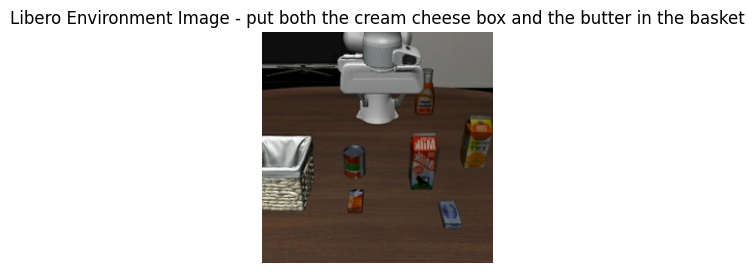

In [38]:
plt.figure(figsize=(5, 3))
plt.imshow(pre_imgs[4])
plt.title(f"Libero Environment Image - {task_description}")
plt.axis('off')
plt.show()

In [103]:
imgs = [get_libero_image(state, resize_size) for state in states]

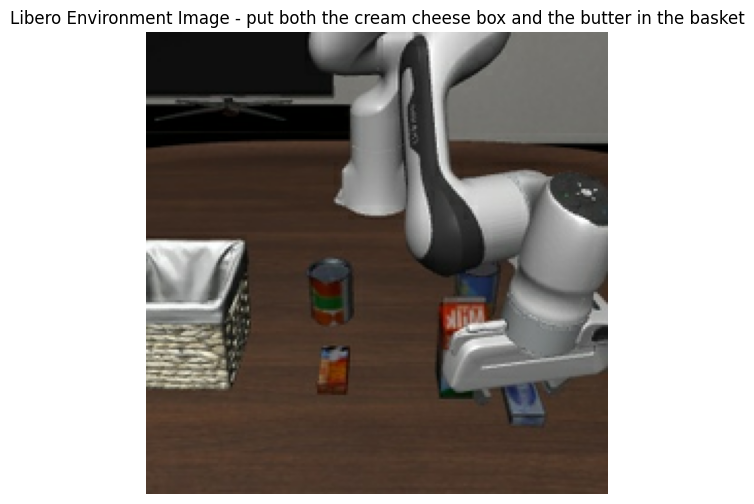

In [31]:
plt.figure(figsize=(8, 6))
plt.imshow(get_libero_image(states[55], resize_size))
plt.title(f"Libero Environment Image - {task_description}")
plt.axis('off')
plt.show()

In [123]:
import imageio
mp4_path = "test56.mp4"
video_writer = imageio.get_writer(mp4_path, fps=30)
for img in imgs:
    video_writer.append_data(img)
video_writer.close()

In [126]:
print(done)

True


In [49]:
# Test get_initial_state multiple times to see randomness
print(f"\n6. Testing get_initial_state method (multiple runs)...")

for test_idx in range(220):
    print(f"Testing with trajectory index: {test_idx}")

    # Get trajectory data
    trajectory = dataset.get_trajectory_data(test_idx)
    print(f"\n--- Test run {test_idx+1} ---")
    
    try:
        # Call get_initial_state
        inputs, start_idx = dataset.get_initial_state(
            trajectory, 
            cfg.pretrained_checkpoint, 
            processor, 
            cfg.device
        )
        
        print(f"Start index: {start_idx}")
        # print(f"Input keys: {list(inputs.keys())}")
        
        # # Check input_ids shape and content
        # if 'input_ids' in inputs:
        #     input_ids = inputs['input_ids']
        #     print(f"Input IDs shape: {input_ids.shape}")
        #     print(f"Input IDs dtype: {input_ids.dtype}")
        #     print(f"Input IDs device: {input_ids.device}")
            
        #     # Decode first few tokens to see the prompt
        #     if hasattr(processor, 'tokenizer'):
        #         decoded = processor.tokenizer.decode(input_ids[0][:50], skip_special_tokens=False)
        #         print(f"Decoded prompt (first 50 tokens): {decoded}")
        
        # # Check pixel_values shape and content  
        # if 'pixel_values' in inputs:
        #     pixel_values = inputs['pixel_values']
        #     print(f"Pixel values shape: {pixel_values.shape}")
        #     print(f"Pixel values dtype: {pixel_values.dtype}")
        #     print(f"Pixel values device: {pixel_values.device}")
        #     print(f"Pixel values range: [{pixel_values.min():.4f}, {pixel_values.max():.4f}]")
        
        # # Check attention_mask if present
        # if 'attention_mask' in inputs:
        #     attention_mask = inputs['attention_mask']
        #     print(f"Attention mask shape: {attention_mask.shape}")
        #     print(f"Attention mask sum: {attention_mask.sum()}")
            
    except Exception as e:
        print(f"ERROR in test run {i+1}: {e}")
        import traceback
        traceback.print_exc()



6. Testing get_initial_state method (multiple runs)...
Testing with trajectory index: 0
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

--- Test run 1 ---
Start index: 240
Testing with trajectory index: 1
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

--- Test run 2 ---
Start index: 328
Testing with trajectory index: 2
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

--- Test run 3 ---
Start index: 143
Testing with trajectory index: 3
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

--- Test run 4 ---
Start index: 115
Testing with trajectory index: 4
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

--- Test run 5 ---
Start index: 37
Testing with trajectory index: 5
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

--- Test run 6 ---
Start index: 90
Testing with trajectory index: 6
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

--- Test run 7 ---
Start index: 170
Testing with trajectory index: 7
[info] using task orders [0, 1,

KeyboardInterrupt: 

In [20]:

# 7. Test with different trajectories
print(f"\n7. Testing with different trajectories...")

max_test_trajectories = min(3, len(dataset))
for idx in range(max_test_trajectories):
    print(f"\n--- Testing trajectory {idx} ---")
    try:
        trajectory = dataset.get_trajectory_data(idx)
        inputs, start_idx = dataset.get_initial_state(
            trajectory, 
            cfg.pretrained_checkpoint, 
            processor, 
            cfg.device
        )
        
        print(f"Trajectory {idx}: Task {trajectory['task_num']}, Start idx: {start_idx}, States: {len(trajectory['state'])}")
        print(f"Input shapes: input_ids={inputs['input_ids'].shape}, pixel_values={inputs['pixel_values'].shape}")
        
    except Exception as e:
        print(f"ERROR with trajectory {idx}: {e}")

print("\n" + "=" * 60)
print("Test completed!")
print("=" * 60)


7. Testing with different trajectories...

--- Testing trajectory 0 ---
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Trajectory 0: Task 2, Start idx: 6, States: 27
Input shapes: input_ids=torch.Size([1, 27]), pixel_values=torch.Size([1, 6, 224, 224])

--- Testing trajectory 1 ---
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Trajectory 1: Task 6, Start idx: 44, States: 479
Input shapes: input_ids=torch.Size([1, 37]), pixel_values=torch.Size([1, 6, 224, 224])

--- Testing trajectory 2 ---
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Trajectory 2: Task 5, Start idx: 53, States: 74
Input shapes: input_ids=torch.Size([1, 30]), pixel_values=torch.Size([1, 6, 224, 224])

Test completed!
